# Antiderivative SpectralSVR (Proof of concept)

In [1]:
import torch
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import pandas as pd
from SpectralSVR import (
    SpectralSVR,
    FourierBasis,
    StandardScaler,
    Antiderivative,
    LSSVR,
    to_real_coeff,
    to_complex_coeff,
    get_metrics,
)
from notebooks.utils import save_to_pgf

In [2]:
plt.rcParams.update(
    {
        # "text.usetex": True,  # use TeX for all texts
        "font.family": "serif",
        "font.size": 12,  # control font sizes of different elements
        # "pgf.rcfonts": False,    # don't setup fonts from rc parameters
        "figure.constrained_layout.use": True,
    }
)
out_folder = "out/"

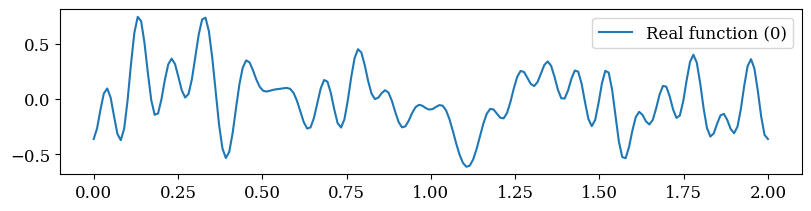

In [4]:
# Set seed
generator = torch.Generator().manual_seed(42)
# domain
domain = slice(0, 2, 500)
periods = (domain.stop - domain.start,)
# Generate functions/data
n_coeffs = 5000
modes = 50
u0 = 0  # integration constant
problem = Antiderivative()
u_clean, f_clean = problem.generate(
    FourierBasis, n=n_coeffs, modes=modes, generator=generator, u0=u0, periods=periods
)
plt.figure(figsize=(8, 2))
u_clean.plot()

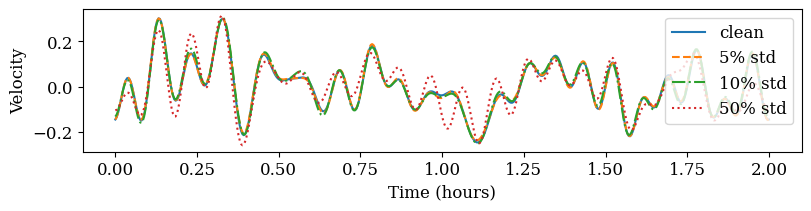

(50,)

In [5]:
# Add noise 1%
u_5 = u_clean.perturb(std_ratio=0.05, generator=generator)
f_5 = f_clean.perturb(std_ratio=0.05, generator=generator)
# Add noise 10%
u_10 = u_clean.perturb(std_ratio=0.10, generator=generator)
f_10 = f_clean.perturb(std_ratio=0.10, generator=generator)
# Add noise 50%
u_50 = u_clean.perturb(std_ratio=0.50, generator=generator)
f_50 = f_clean.perturb(std_ratio=0.50, generator=generator)


plt.figure(figsize=(8, 2))
u_clean.plot(res=domain)
u_5.plot(res=domain, linestyle="--")
u_10.plot(res=domain, linestyle="-.")
u_50.plot(res=domain, linestyle=":")
plt.xlabel("Time (hours)")
plt.ylabel("Velocity")
plt.legend(["clean", "5% std", "10% std", "50% std"], loc="upper right")
save_to_pgf(out_folder + "antiderivative_clean_perturbed_solution.pgf")
plt.show()
f_50.modes

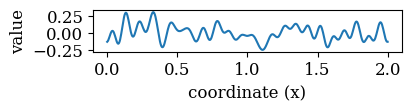

In [6]:
plt.figure(figsize=(4, 1))
u_10.plot(res=domain, legend=False)
plt.xlabel("coordinate (x)")
plt.ylabel("value")
save_to_pgf(out_folder + "example_function.pgf")

In [7]:
torch.set_printoptions(precision=2)
u_10.get_values().real

tensor([[-1.31,  0.27, -1.57,  ..., -0.34,  1.26, -1.31],
        [-1.01,  0.02, -0.29,  ..., -0.01,  2.19, -1.01],
        [-0.71,  1.05,  0.62,  ..., -0.12,  1.13, -0.71],
        ...,
        [ 0.57, -0.42, -1.65,  ...,  0.17,  1.97,  0.57],
        [ 1.21, -0.15,  1.33,  ..., -0.36,  0.22,  1.21],
        [-1.32, -1.47,  0.75,  ...,  0.90,  0.86, -1.32]])

In [8]:
torch.set_printoptions(precision=2, sci_mode=False)
u_10.coeff

tensor([[     0.71+0.00j,      6.41-7.72j,     -6.84-6.98j,
          ...,      4.93+6.82j,     -6.84+6.98j,
              6.41+7.72j],
        [     0.14-0.00j,      5.72-6.43j,     -5.05+1.52j,
          ...,      4.68-1.75j,     -5.05-1.52j,
              5.72+6.43j],
        [    -0.93+0.00j,      2.24-5.21j,      7.87+2.61j,
          ...,      1.30-0.87j,      7.87-2.61j,
              2.24+5.21j],
        ...,
        [    -0.00+0.00j,      0.30+4.82j,      7.07+0.71j,
          ...,     -0.11-9.84j,      7.07-0.71j,
              0.30-4.82j],
        [    -0.86+0.00j,      4.99-5.74j,     -6.82+3.72j,
          ...,      5.84-1.16j,     -6.82-3.72j,
              4.99+5.74j],
        [     0.76-0.00j,      3.64+6.00j,     -7.63+3.83j,
          ...,     -4.62+2.50j,     -7.63-3.83j,
              3.64-6.00j]])

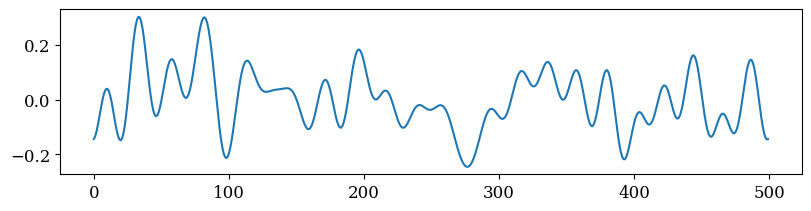

In [9]:
u_val = u_clean.get_values(n=1, res=domain).real[0]
f_val = f_clean.get_values(n=1, res=domain).real[0]
plt.figure(figsize=(8, 2))
plt.plot(u_val)

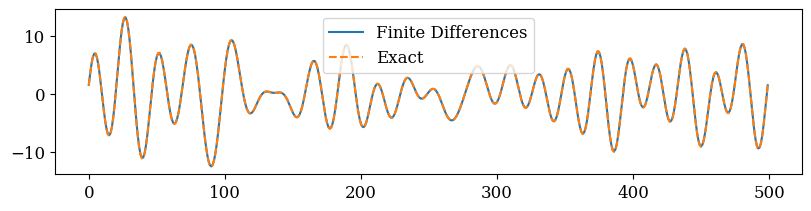

In [10]:
u_grad = torch.gradient(
    u_val, spacing=(domain.stop - domain.start) / domain.step, edge_order=2
)[0]
plt.figure(figsize=(8, 2))
plt.plot(u_grad)
plt.plot(f_val, linestyle="--")
plt.legend(["Finite Differences", "Exact"])

In [11]:
u_clean.generate_coeff(1, 7)

tensor([[-0.31+0.00j, -0.48-0.32j, -1.35+0.05j, -0.07-0.87j, -0.07+0.87j,
         -1.35-0.05j, -0.48+0.32j]])

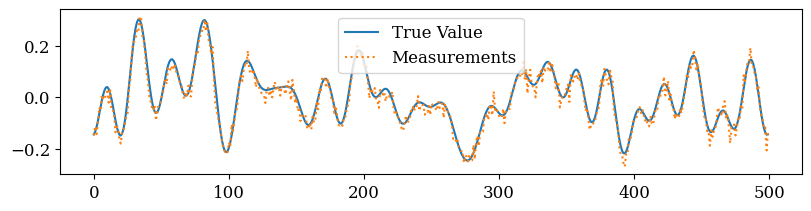

In [12]:
u_noisy = u_val + (torch.randn_like(u_val) - 0.5) * 2 * u_val.std() * 0.1
plt.figure(figsize=(8, 2))
plt.plot(u_val)
plt.plot(u_noisy, linestyle="dotted")
plt.legend(["True Value", "Measurements"])

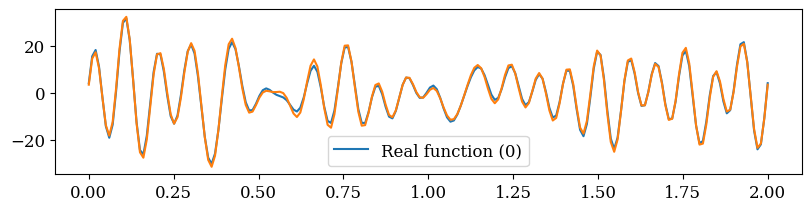

In [13]:
plt.figure(figsize=(8, 2))
u_clean.perturb(std_ratio=0.1).grad().plot()
u_clean.grad().plot()

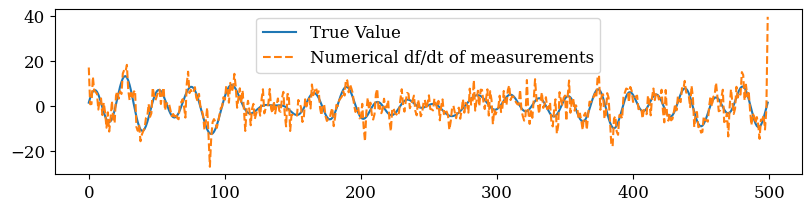

In [14]:
u_grad_noisy = torch.gradient(
    u_noisy, spacing=(domain.stop - domain.start) / domain.step, edge_order=2
)[0]
plt.figure(figsize=(8, 2))
plt.plot(f_val)
plt.plot(u_grad_noisy, linestyle="--")
plt.legend(["True Value", "Numerical df/dt of measurements"])

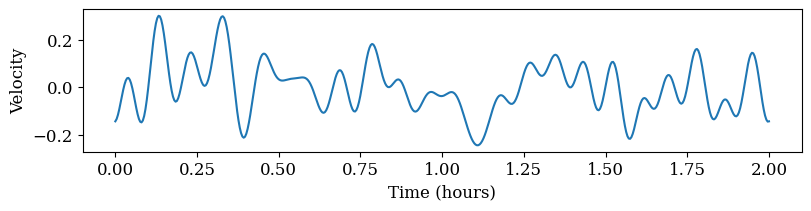

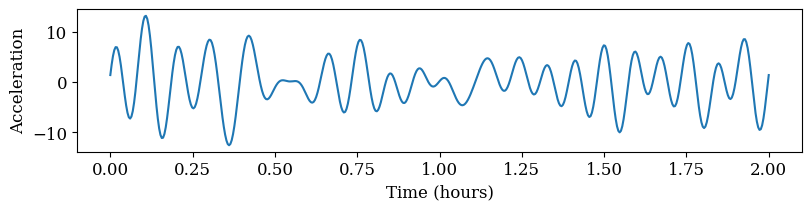

In [15]:
plt.figure(figsize=(8, 2))
u_clean.plot(i=0, res=domain, legend=False)
plt.xlabel("Time (hours)")
plt.ylabel("Velocity")
save_to_pgf(out_folder + "antiderivative_clean.pgf")
plt.show()
plt.figure(figsize=(8, 2))
f_clean.plot(i=0, res=domain, legend=False)
plt.xlabel("Time (hours)")
plt.ylabel("Acceleration")
save_to_pgf(out_folder + "antiderivative_derivative_clean.pgf")
plt.show()

In [16]:
# Train-test split
def get_preprocessed_data(
    f_basis: FourierBasis,
    u_basis: FourierBasis,
    train_test_ratio: tuple[float, float] = (0.8, 0.2),
):
    # Interpolate f & u
    t = FourierBasis.grid(res=domain)
    f = f_basis(t)
    f = f.real

    u = u_basis(t)
    u = u.real
    # df = TensorDataset(f, u, u_fourier.coeff)
    df = TensorDataset(f, f_basis.coeff, u, u_basis.coeff)
    df_train, df_test = random_split(
        df, train_test_ratio, generator=generator
    )  # Scale inputs based on training inputs
    f_train, f_coeff_train, u_train, u_coeff_train = df_train[:]
    # f_input_train = f_train
    f_input_train = f_coeff_train
    scaler = StandardScaler().fit(f_input_train)
    f_input_train = scaler.transform(f_input_train)
    f_test, f_coeff_test, u_test, u_coeff_test = df_test[:]
    # f_input_test = f_test
    f_input_test = f_coeff_test
    f_input_test = scaler.transform(f_input_test)

    return (
        f_input_train,
        u_coeff_train,
        f_input_test,
        u_coeff_test,
        df_train,
        df_test,
        scaler,
    )


In [17]:
# Exact problem
def get_exact_basis():
    t = torch.linspace(domain.start, domain.stop, modes)
    derivative = 2 * torch.pi * torch.cos(2 * torch.pi * t)
    solution = torch.sin(2 * torch.pi * t)
    derivative_coeff = FourierBasis.transform(derivative.unsqueeze(0))
    solution_coeff = FourierBasis.transform(solution.unsqueeze(0))
    return FourierBasis(derivative_coeff, periods=periods), FourierBasis(
        solution_coeff, periods=periods
    )


f_exact, u_exact = get_exact_basis()

In [18]:
f_exact_5 = f_exact.perturb(0.05, generator=generator)
f_exact_10 = f_exact.perturb(0.1, generator=generator)
f_exact_50 = f_exact.perturb(0.5, generator=generator)

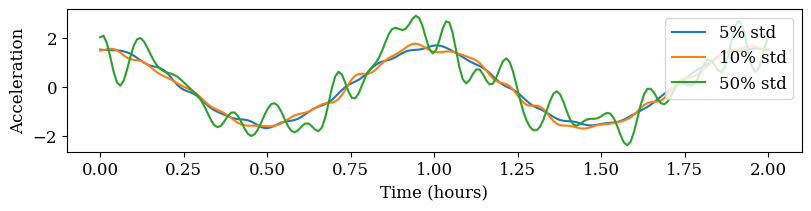

In [19]:
plt.figure(figsize=(8, 2))
f_exact_5.plot()
f_exact_10.plot()
f_exact_50.plot()
# u_exact.plot()
plt.xlabel("Time (hours)")
plt.ylabel("Acceleration")
plt.legend(["5% std", "10% std", "50% std", "target"], loc="upper right")
save_to_pgf(out_folder + "antiderivative_exact_input.pgf")

In [20]:
tmp = StandardScaler().fit(to_real_coeff(u_10.coeff))
tmp.transform(to_real_coeff(u_10.coeff))

tensor([[ 1.00,  0.03,  1.28,  ...,  1.41,  1.28,  1.55],
        [ 0.20, -0.01,  1.15,  ..., -0.31,  1.15,  1.29],
        [-1.31,  0.02,  0.46,  ..., -0.53,  0.46,  1.04],
        ...,
        [-0.01,  0.01,  0.07,  ..., -0.14,  0.07, -0.97],
        [-1.21,  0.01,  1.00,  ..., -0.75,  1.00,  1.15],
        [ 1.07, -0.00,  0.73,  ..., -0.78,  0.73, -1.20]])

In [21]:
to_real_coeff(f_10.coeff)

tensor([[    60.55,      0.00,    -24.75,  ...,     30.82,    -24.75,
             -4.53],
        [   -55.26,     -0.00,      4.36,  ...,     25.72,      4.36,
             -0.91],
        [     8.86,      0.00,     51.26,  ...,    -42.58,     51.26,
            -25.38],
        ...,
        [    31.76,     -0.00,    -20.23,  ...,    -40.02,    -20.23,
            -33.00],
        [    13.99,      0.00,     28.29,  ...,     48.39,     28.29,
             18.41],
        [   -17.62,      0.00,    -27.08,  ...,     15.81,    -27.08,
             26.88]])

In [22]:
# def trapezoidal(f: FourierBasis, res: int) -> FourierBasis:
#     f_val, grid = f.get_values_and_grid(res=res)
#     dx = grid[1, 0] - grid[0, 0]
#     u_val = f_val.cumsum(1) * dx

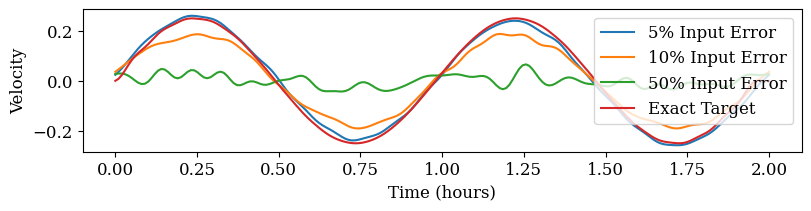

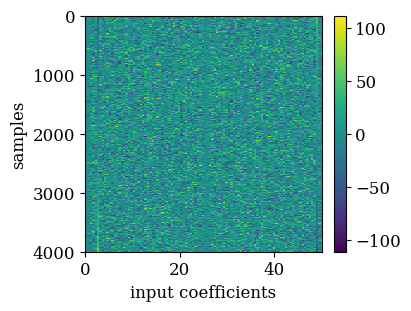

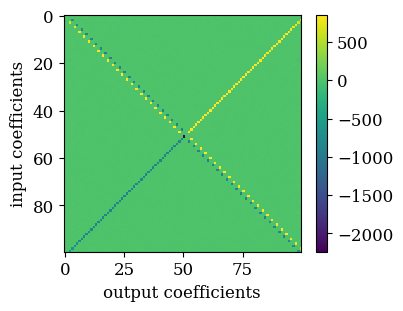

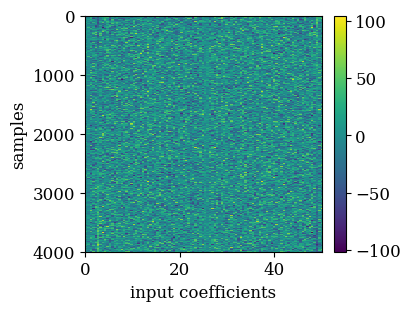

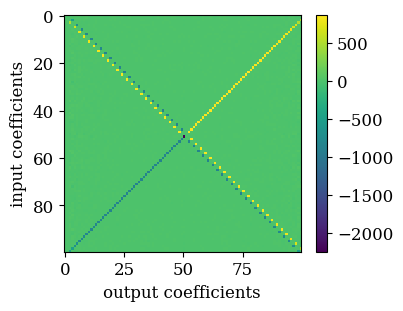

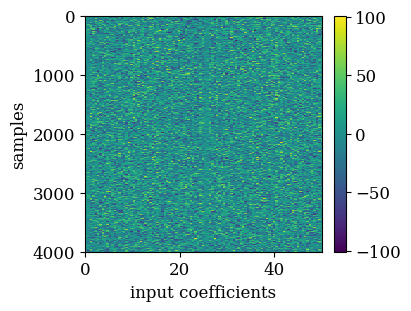

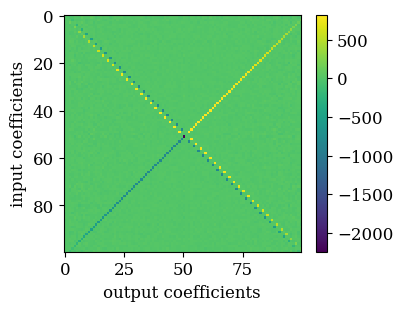

In [23]:
# Train svm
sets = [
    (f_5, u_5, f_exact_5, u_exact),
    (f_10, u_10, f_exact_10, u_exact),
    (f_50, u_50, f_exact_50, u_exact),
]
spectral_results = {}
function_results = {}
clean_spectral_results = {}
clean_function_results = {}
exact_spectral_results = {}
exact_function_results = {}
inv_spectral_results = {}
legend = []
exact_fig, exact_ax = plt.subplots(figsize=(8, 2))
interp_fig = []
interp_ax = []
for i, (percentage, data) in enumerate(zip(["5", "10", "50"], sets, strict=True)):
    f, u, input_exact, output_exact = data
    input_train, output_train, input_test, output_test, df_train, df_test, scaler = (
        get_preprocessed_data(f, u)
    )
    model = SpectralSVR(
        FourierBasis(periods=periods),
        regressor=LSSVR(
            C=1.0,
            device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
        ),
        verbose=None,
    )
    model.train(input_train, output_train)
    sigma = model.regressor.kernel_params.get("sigma")
    assert isinstance(sigma, torch.Tensor), "Make sure the kernel is RBF"
    sigma = sigma.cpu().item()

    metrics = model.test(input_test, output_test)
    percentage_label = f"{percentage}%"
    spectral_results = {
        **spectral_results,
        percentage_label: {
            "sigma": sigma,
            **metrics["spectral"],
        },
    }
    function_results = {
        **function_results,
        percentage_label: {
            "sigma": sigma,
            **metrics["function value"],
        },
    }
    clean_metrics = model.test(input_test, u_clean.coeff[df_test.indices])
    clean_spectral_results = {
        **clean_spectral_results,
        percentage_label: {
            **clean_metrics["spectral"],
        },
    }
    clean_function_results = {
        **clean_function_results,
        percentage_label: {
            **clean_metrics["function value"],
        },
    }

    # Exact problem
    exact_input = scaler.transform(input_exact.coeff)
    exact_metrics = model.test(exact_input, output_exact.coeff)
    exact_spectral_results = {
        **exact_spectral_results,
        percentage_label: {
            **exact_metrics["spectral"],
        },
    }
    exact_function_results = {
        **exact_function_results,
        percentage_label: {
            **exact_metrics["function value"],
        },
    }
    pred_exact = FourierBasis(
        to_complex_coeff(model.regressor.predict(to_real_coeff(exact_input))),
        periods=periods,
    )
    pred_exact.plot(plt=exact_ax)
    legend = [*legend, f"{percentage_label} Input Error"]
    # inverse problem
    inv_pred = model.inverse_coeff(
        output_test, epochs=2000, lr=1e-2, generator=generator
    )
    inv_metrics = get_metrics(
        to_real_coeff(scaler.inverse(inv_pred)),
        to_real_coeff(scaler.inverse(input_test)),
    )
    inv_spectral_results = {**inv_spectral_results, percentage_label: {**inv_metrics}}
    # inverse plots vs spectral derivative

    # interpretations
    tmp_fig, tmp_ax = plt.subplots(figsize=(4, 3))
    interp_fig.append(tmp_fig)
    interp_ax.append(tmp_ax)
    fig_index = 2 * i
    corr = model.regressor.get_correlation_image().cpu()
    sorted = output_train.real[:, 2].sort()
    im = interp_ax[fig_index].imshow(
        corr[sorted.indices.cpu(), :],
        interpolation="none",
        aspect="auto",
        extent=(0, modes, corr.shape[0], 0),
    )
    interp_ax[fig_index].set_ylabel("samples")
    interp_ax[fig_index].set_xlabel("input coefficients")
    interp_fig[fig_index].colorbar(im, ax=interp_ax[fig_index])
    save_to_pgf(
        out_folder + f"antiderivative_ci_{percentage}.pgf", plt=interp_fig[fig_index]
    )

    tmp_fig, tmp_ax = plt.subplots(figsize=(4, 3))
    interp_fig.append(tmp_fig)
    interp_ax.append(tmp_ax)
    fig_index = 2 * i + 1
    p_mat = model.regressor.get_p_matrix().cpu()
    im = interp_ax[fig_index].imshow(p_mat[:, :], interpolation="none", aspect="equal")
    # plt.imshow(p_mat[:,2][:,None], interpolation="none", aspect="auto", extent=(0,10,0,10))
    interp_ax[fig_index].set_xlabel("output coefficients")
    interp_ax[fig_index].set_ylabel("input coefficients")
    interp_fig[fig_index].colorbar(im, ax=interp_ax[2 * i + 1])
    save_to_pgf(
        out_folder + f"antiderivative_pm_{percentage}.pgf", plt=interp_fig[fig_index]
    )

u_exact.plot(plt=exact_ax)
exact_ax.legend([*legend, "Exact Target"])
exact_ax.set_xlabel("Time (hours)")
exact_ax.set_ylabel("Velocity")
save_to_pgf(out_folder + "antiderivative_exact_prediction.pgf", plt=exact_fig)
# exact_fig

In [24]:
function_results

{'5%': {'sigma': 10.001250267028809,
  'mse': 0.03426966816186905,
  'rmse': 0.18512068688869476,
  'mae': 0.14663062989711761,
  'r2': 0.9653169512748718,
  'smape': 0.38868772983551025,
  'rse': 0.034683141857385635,
  'rrse': 0.18615196645259857,
  'pred_nan_sum': 0},
 '10%': {'sigma': 10.001250267028809,
  'mse': 0.08216577768325806,
  'rmse': 0.2866457402706146,
  'mae': 0.22878822684288025,
  'r2': 0.9174004197120667,
  'smape': 0.5480043888092041,
  'rse': 0.08259958028793335,
  'rrse': 0.2873069643974304,
  'pred_nan_sum': 0},
 '50%': {'sigma': 10.001250267028809,
  'mse': 0.6235525012016296,
  'rmse': 0.7896534204483032,
  'mae': 0.6296483278274536,
  'r2': 0.4953327178955078,
  'smape': 1.044425129890442,
  'rse': 0.5046672224998474,
  'rrse': 0.7102282643318176,
  'pred_nan_sum': 0}}

In [25]:
spectral_results_df = pd.DataFrame(spectral_results).T
spectral_results_df.index.name = "Noise level"
spectral_results_df.style.format(precision=2).to_latex(out_folder+"tmp.tex")

In [26]:
function_results_df = pd.DataFrame(function_results).T
function_results_df.index.name = "Noise level"
function_results_df.style.format(precision=2).to_latex(out_folder+"tmp.tex")

In [27]:
clean_spectral_results_df = pd.DataFrame(clean_spectral_results).T
clean_spectral_results_df.index.name = "Noise level"
clean_spectral_results_df.style.format(precision=2).to_latex(out_folder+"tmp.tex")

In [28]:
clean_function_results_df = pd.DataFrame(clean_function_results).T
clean_function_results_df.index.name = "Noise level"
clean_function_results_df.style.format(precision=2).to_latex(out_folder+"tmp.tex")

In [29]:
exact_spectral_results_df = pd.DataFrame(exact_spectral_results).T
exact_spectral_results_df.index.name = "Noise level"
exact_spectral_results_df.style.format(precision=2).to_latex(out_folder+"tmp.tex")

In [30]:
exact_function_results_df = pd.DataFrame(exact_function_results).T
exact_function_results_df.index.name = "Noise level"
exact_function_results_df.style.format(precision=2).to_latex(out_folder+"tmp.tex")

In [31]:
inv_spectral_results_df = pd.DataFrame(inv_spectral_results).T
inv_spectral_results_df.index.name = "Noise level"
inv_spectral_results_df.style.format(precision=2).to_latex(out_folder+"tmp.tex")

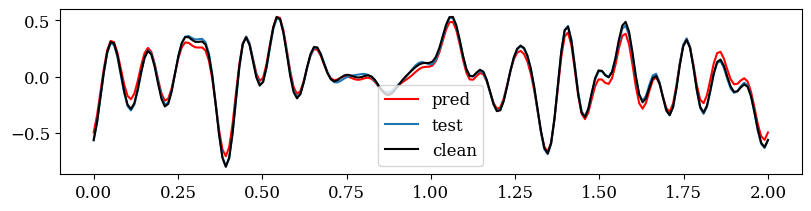

In [32]:
input_train, output_train, input_test, output_test, df_train, df_test, scaler = (
    get_preprocessed_data(f_5, u_5)
)
model = SpectralSVR(
    FourierBasis(periods=periods),
    regressor=LSSVR(
        C=1.0,
        device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    ),
    verbose=None,
)
model.train(input_train, output_train)
sigma = model.regressor.kernel_params.get("sigma")
assert isinstance(sigma, torch.Tensor), "Make sure the kernel is RBF"
sigma = sigma.cpu().item()

metrics = model.test(input_test, output_test)
clean_metrics = model.test(input_test, u_clean.coeff[df_test.indices])
u_pred = model.regressor.predict(to_real_coeff(input_test))

u_pred = FourierBasis(to_complex_coeff(u_pred), periods=periods)
plt.figure(figsize=(8, 2))
i = 2
u_pred[i].plot(color="r")
u_5[df_test.indices[i]].plot()
u_clean[df_test.indices[i]].plot(color="k")
plt.legend(["pred", "test", "clean"])
# save_to_pgf(out_folder+"")
plt.show()

In [33]:
inv_pred = model.inverse_coeff(
    output_test,
    epochs=2000,
    lr=1e-2,
)
inv_pred = scaler.inverse(inv_pred)
inv = model.basis.copy()
inv.coeff = inv_pred
# inv_metrics = get_metrics(to_real_coeff(inv_pred), to_real_coeff(input_test))
# inv_spectral_results = {**inv_spectral_results, percentage_label: {**inv_metrics}}

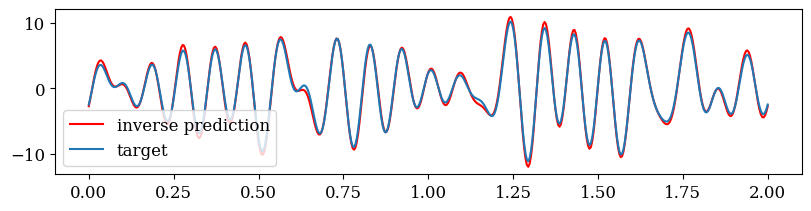

In [34]:
plt.figure(figsize=(8, 2))
inv.plot(i=3, c="r", res=500)
f_clean[df_test.indices].plot(i=3, res=500)
plt.legend(["inverse prediction", "target"])
save_to_pgf(out_folder + "antiderivative_inverse.pgf")

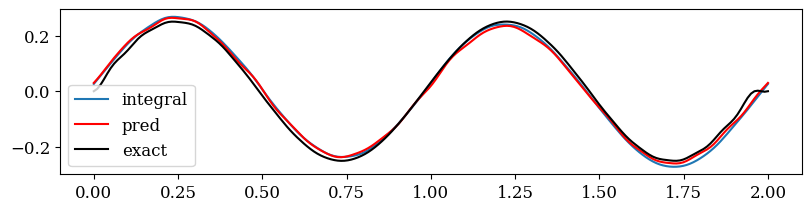

In [35]:
exact_input = to_real_coeff(scaler.transform(f_exact_5.coeff))
u_pred = FourierBasis(
    to_complex_coeff(model.regressor.predict(exact_input)), periods=periods
)
plt.figure(figsize=(8, 2))
# f_single.plot()
f_exact_5.integral().plot()
u_pred.plot(color="r")
u_exact.plot(color="k")
plt.legend(["integral", "pred", "exact"])
# save_to_pgf(out_folder+"")
plt.show()

In [36]:
u_pred.coeff.shape

torch.Size([1, 50])

In [37]:
u_exact.coeff.shape

torch.Size([1, 50])

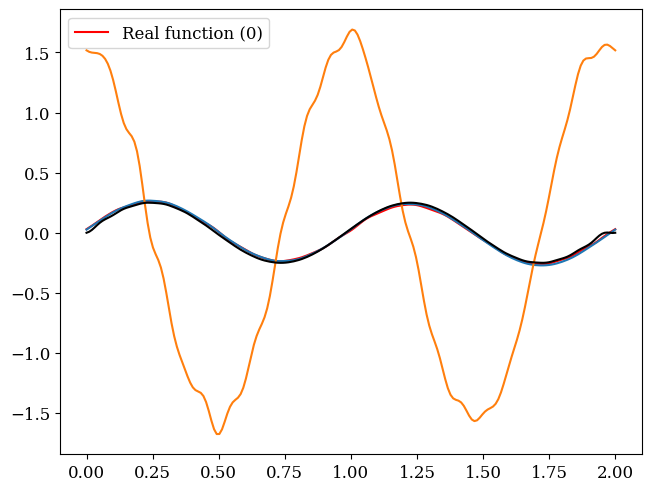

In [38]:
u_pred.plot(color="r")
f_exact_5.integral().plot()
f_exact_5.plot()
u_exact.plot(color="k")

(torch.Size([4000, 100]),
 torch.return_types.sort(
 values=tensor([-17.69, -17.60, -16.56,  ...,  15.71,  16.54,  18.94]),
 indices=tensor([1372, 1164, 1342,  ...,    4, 1344, 1726])))

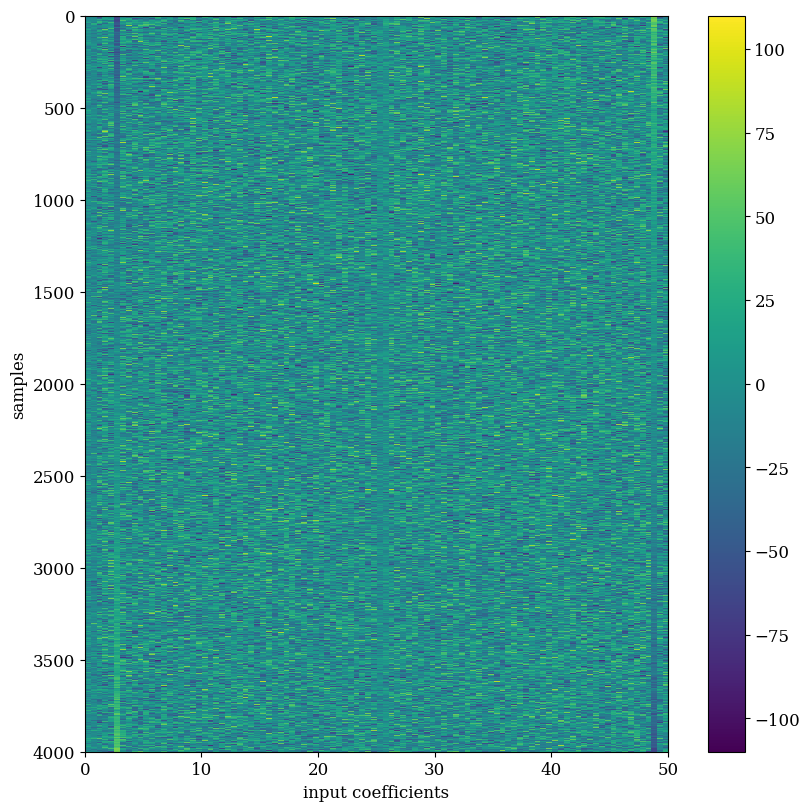

In [39]:
corr = model.regressor.get_correlation_image().cpu()
sorted = output_train.real[:, 2].sort()
plt.figure(figsize=(8, 8))
plt.imshow(
    corr[sorted.indices.cpu(), :],
    interpolation="none",
    aspect="auto",
    extent=(0, modes, corr.shape[0], 0),
)
plt.ylabel("samples")
plt.xlabel("input coefficients")
plt.colorbar()
corr.shape, sorted


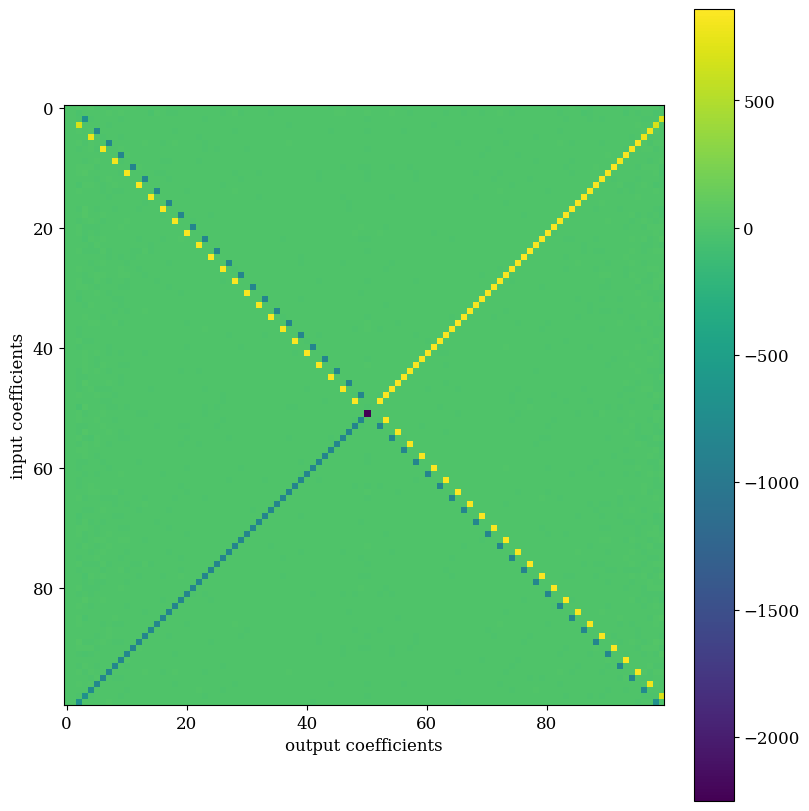

In [40]:
p_mat = model.regressor.get_p_matrix().cpu()
plt.figure(figsize=(8, 8))
plt.imshow(p_mat[:, :], interpolation="none", aspect="equal")
# plt.imshow(p_mat[:,2][:,None], interpolation="none", aspect="auto", extent=(0,10,0,10))
plt.colorbar()
plt.xlabel("output coefficients")
plt.ylabel("input coefficients")
plt.show()

In [41]:
u_clean[0].coeff, u_clean[0].grad().coeff

(tensor([[ 0.00+0.00j,  5.96-7.55j, -6.47-6.09j,  4.57-7.38j,
          -8.75+8.76j, -5.10-7.10j,  0.06-0.28j,  1.32+2.51j,
           7.70-2.42j, -6.50+3.62j, -2.64+5.01j, -4.97+8.60j,
           6.56+6.85j,  2.36+3.21j, -1.43-1.70j, -4.62-1.48j,
          -3.67-2.38j,  7.05+4.22j,  6.24-4.53j, -3.11-7.63j,
          -5.85-3.00j, -3.33-4.51j, -9.47+7.38j, -7.24+0.88j,
          -4.96-6.54j,  0.55-0.00j, -4.96+6.54j, -7.24-0.88j,
          -9.47-7.38j, -3.33+4.51j, -5.85+3.00j, -3.11+7.63j,
           6.24+4.53j,  7.05-4.22j, -3.67+2.38j, -4.62+1.48j,
          -1.43+1.70j,  2.36-3.21j,  6.56-6.85j, -4.97-8.60j,
          -2.64-5.01j, -6.50-3.62j,  7.70+2.42j,  1.32-2.51j,
           0.06+0.28j, -5.10+7.10j, -8.75-8.76j,  4.57+7.38j,
          -6.47+6.09j,  5.96+7.55j]]),
 tensor([[     0.00+0.00j,     23.70+18.72j,     38.27-40.68j,
              69.58+43.04j,   -110.03-109.94j,    111.49-80.08j,
               5.19+1.07j,    -55.27+28.95j,     60.80+193.58j,
            -102.46-183.7